In [3]:
import os
import glob
import sys
import subprocess
import xarray as xr
import numpy as np
import pandas as pd
from time import perf_counter
import matplotlib.pyplot as plt
import datetime

THIS_DIR = os.path.abspath('')
sys.path.append(os.path.join(THIS_DIR, os.pardir, os.pardir))


from src.postprocessing.qnc_defintions import Output_format
from src.postprocessing.qnc_output_parser import QNC_output_parser
from src.postprocessing.qnc_ncdf_reader import QNC_ncdf_reader
    
OUTPUT_DIR = '/Net/Groups/BSI/scratch/ppapastefanou/simulations/QPy/09_transient_latin_hypercube_with_std'

In [4]:
import scipy

     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.0 sec.)
     Reading variable names and units... Done! (0.0 sec.)
     Reading all 1D variables... Done! (0.0 sec.)
0
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.0 sec.)
     Reading variable names and units... Done! (0.0 sec.)
     Reading all 1D variables... Done! (0.0 sec.)
10
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.0 sec.)
     Reading variable names and units... Done! (0.0 sec.)
     Reading all 1D variables... Done! (0.0 sec.)
20
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.0 sec.)
     Reading variable names and units... Done! (0.0 sec.)
     Reading all 1D variables... Done! (0.0 sec.)
30
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.0 sec.)
     Reading variable names and units... Done! (0.0 sec.)
    

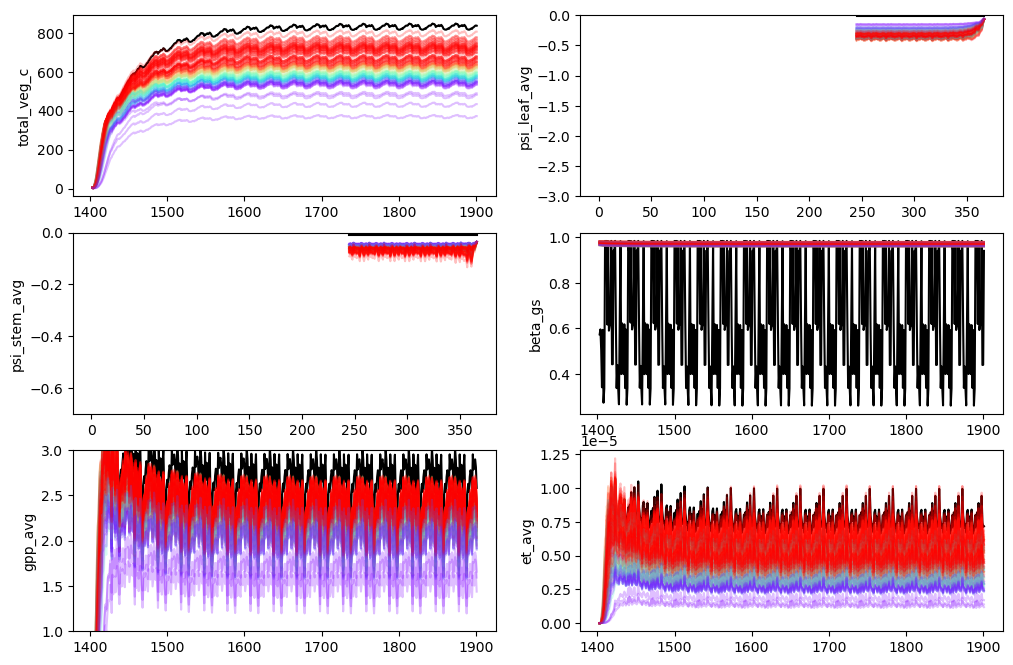

In [12]:
fig = plt.figure(figsize=(12,8))

ax_veg = fig.add_subplot(3, 2, 1)
ax_psi_leaf = fig.add_subplot(3, 2, 2)
ax_psi_leaf24 = fig.add_subplot(3, 2, 3)
ax_gs= fig.add_subplot(3, 2, 4)
ax_gpp = fig.add_subplot(3, 2, 5)
ax_et = fig.add_subplot(3, 2, 6)

for fid in range(0,1000, 10):
    parser = QNC_output_parser(os.path.join(OUTPUT_DIR,'output', str(fid)))
    parser.Read()
    output = parser.Available_outputs['spinup']
    nc_output = QNC_ncdf_reader(os.path.join(OUTPUT_DIR, 'output', str(fid)),
                                            output.Categories,
                                            output.Identifier,
                                            output.Time_resolution
                                            )

    nc_output.Parse_env_and_variables()
    nc_output.Read_all_1D()
    nc_output.Close()
    dfs_veg = nc_output.Datasets_1D['VEG'].groupby(pd.Grouper(key='date', freq='1YE')).mean()
    
    minc = 500
    maxc = 600
    s = maxc-minc
    
    vegmean = dfs_veg['total_veg_c'].mean()
    print(fid)
    
    if fid == 0:
        col = 'black'
        alpha = 1.0
    else:
        col = plt.cm.rainbow(-minc/s + vegmean/s)
        alpha = 0.25
    
    dfs_psi = nc_output.Datasets_1D['PHYD'].groupby(pd.Grouper(key='date', freq='d')).mean()
    dfs_assimi_year = nc_output.Datasets_1D['Q_ASSIMI'].groupby(pd.Grouper(key='date', freq='1YE')).mean()
    dfs_spq_yearly = nc_output.Datasets_1D['SPQ'].groupby(pd.Grouper(key='date', freq='1YE')).mean()
    
    dfs_psi['dayofyear'] = dfs_psi.index.dayofyear
    dfs_psi  = dfs_psi.groupby('dayofyear').mean()

    ax_veg.plot(dfs_veg['total_veg_c'], c = col, alpha = alpha)

    
    ax_gpp.plot(dfs_assimi_year['gpp_avg'], c = col, alpha = alpha)
    ax_gpp.set_ylim(1.0, 3.0)
    ax_psi_leaf.plot(dfs_psi['psi_leaf_avg'], c = col, alpha = alpha)
    ax_psi_leaf.set_ylim(-3,0)
    ax_psi_leaf24.plot(dfs_psi['psi_stem_avg'], c = col, alpha = alpha)
    ax_psi_leaf24.set_ylim(-0.7,0)
    ax_et.plot(dfs_spq_yearly['transpiration_avg'], c = col , alpha = alpha)
    ax_gs.plot(dfs_assimi_year['beta_gs'], c = col, alpha = alpha)

ax_veg.set_ylabel('total_veg_c')
ax_gpp.set_ylabel('gpp_avg')
ax_psi_leaf.set_ylabel('psi_leaf_avg')
ax_psi_leaf24.set_ylabel('psi_stem_avg')
ax_et.set_ylabel('et_avg')
ax_gs.set_ylabel('beta_gs')


plt.savefig(os.path.join(OUTPUT_DIR,"Overview.png"))
plt.show()


In [13]:
from src.postprocessing.qnc_obs_model_comparer import QNC_Obs_Model_Variable_Pair, QNC_Variable
from src.postprocessing.qnc_std_fluxnet_diagnostics import Obs_Model_Var_List
from src.postprocessing.qnc_obs_reader import QNC_obs_reader

In [14]:
nc_obs = QNC_obs_reader('/Net/Groups/BSI/data/OCN/evaluation/point/FLUXNET/v2/DE-Hai.2000-2006.obs.nc')
nc_obs.Parse_env_and_variables()

nc_obs

In [15]:
#Defining standard fluxnet output
obs_var_collection = Obs_Model_Var_List()

omp = QNC_Obs_Model_Variable_Pair(name="Gc")
omp.Plus_model_var(QNC_Variable("gc_avg", "Q_ASSIMI"))
omp.Plus_obs_var(QNC_Variable("Gc"))
obs_var_collection.Add(omp)

omp = QNC_Obs_Model_Variable_Pair(name="GPP")
omp.Plus_model_var(QNC_Variable("gpp_avg", "Q_ASSIMI"))
omp.Plus_obs_var(QNC_Variable("GPP"))
obs_var_collection.Add(omp)

omp = QNC_Obs_Model_Variable_Pair(name="NEE")
omp.Plus_model_var(QNC_Variable("het_respiration_avg", "SB"))
omp.Substract_model_var(QNC_Variable("npp_avg", "VEG"))
omp.Plus_obs_var(QNC_Variable("NEE"))
obs_var_collection.Add(omp)

omp = QNC_Obs_Model_Variable_Pair(name="Ga")
omp.Plus_model_var(QNC_Variable("ga_avg", "A2L"))
omp.Plus_obs_var(QNC_Variable("Ga"))
obs_var_collection.Add(omp)

omp = QNC_Obs_Model_Variable_Pair(name="LE")
omp.Substract_model_var(QNC_Variable("qle_avg", "SPQ"))
omp.Plus_obs_var(QNC_Variable("LE"))
obs_var_collection.Add(omp)

omp = QNC_Obs_Model_Variable_Pair(name="H")
omp.Substract_model_var(QNC_Variable("qh_avg", "SPQ"))
omp.Plus_obs_var(QNC_Variable("H"))
obs_var_collection.Add(omp)

omp = QNC_Obs_Model_Variable_Pair(name="Reco")
omp.Plus_model_var(QNC_Variable("het_respiration_avg", "SB"))
omp.Plus_model_var(QNC_Variable("gpp_avg", "Q_ASSIMI"))
omp.Substract_model_var(QNC_Variable("npp_avg", "VEG"))

omp = QNC_Obs_Model_Variable_Pair(name="PPFD")
omp.Plus_model_var(QNC_Variable("appfd_avg", "Q_RAD"))
omp.Plus_obs_var(QNC_Variable("PPFD"))
obs_var_collection.Add(omp)

In [6]:
obs_var_collection.Get_obs_var_list()

[['Gc'], ['GPP'], ['NEE'], ['Ga'], ['LE'], ['H'], ['PPFD']]

In [7]:
pair = obs_var_collection.Target_variables[1]

In [8]:
def get_obs_df(pair : QNC_Obs_Model_Variable_Pair):
    obs_plus = []
    for var in pair.obs_vars_plus:
        df = nc_obs.Read_data(var.name)
        obs_plus.append(df)

    obs_minus = []
    for var in pair.obs_vars_minus:
        df = nc_obs.Read_data(var.name)
        obs_minus.append(df)    

    i = 0
    for var in pair.obs_vars_plus:
        if i == 0:
            dfs_obs = obs_plus[0]
            dfs_obs[pair.name] = dfs_obs[var.name]
        else:
            dfs_obs[pair.name] += obs_plus[i][var.name]
        i += 1

    i = 0
    for var in pair.obs_vars_minus:
        dfs_obs[pair.name] -= obs_minus[i][var.name]
        i += 1
    return dfs_obs

In [9]:
def get_mod_df(nc_output :QNC_ncdf_reader , pair : QNC_Obs_Model_Variable_Pair):
    model_plus = []
    for var in pair.model_vars_plus:
        df = nc_output.read_1D_flat(var.cat, var.name)
        df.set_index('date', inplace=True)
        model_plus.append(df)

    model_minus = []
    for var in pair.model_vars_minus:
        df = nc_output.read_1D_flat(var.cat, var.name)
        df.set_index('date', inplace=True)
        model_minus.append(df)

    i = 0
    for var in pair.model_vars_plus:
        if i == 0:
            dfs_model = model_plus[0]
            dfs_model[pair.name] = dfs_model[var.name]
        else:
            dfs_model[pair.name] += model_plus[i][var.name]
        i += 1

    i = 0

    for var in pair.model_vars_minus:
        if (i == 0) & (len(pair.model_vars_plus) == 0):
            dfs_model = model_minus[0]
            dfs_model[pair.name] = -dfs_model[var.name]
        else:
            dfs_model[pair.name] -= model_minus[i][var.name]
        i += 1
    return dfs_model

In [10]:
dfs_obs = get_obs_df(pair=pair)

In [11]:
dfs_obs[dfs_obs['GPP'] < 0.0] = 0.0 

In [12]:
fid = 0 
parser = QNC_output_parser(os.path.join(OUTPUT_DIR,'output', str(fid)))
parser.Read()
output = parser.Available_outputs['fluxnetdata']
nc_output = QNC_ncdf_reader(os.path.join(OUTPUT_DIR, 'output', str(fid)),
                                        output.Categories,
                                        output.Identifier,
                                        output.Time_resolution
                                        )

nc_output.Parse_env_and_variables()
dfs_mod = get_mod_df(nc_output=nc_output, pair = pair)

nc_output.Close()

     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.5 sec.)
     Reading variable names and units... Done! (0.5 sec.)
Reading 1D variable... Done! (0.0 sec.)


In [13]:
dfs_mod.shape

(122640, 3)

In [14]:
dfs_mod['GPP_obs'] = dfs_obs['GPP']
dfs_mod.dropna(inplace=True)
dfs_mod

,index,gpp_avg,GPP,GPP_obs
date,,,,
2000-01-01 00:00:00,0,0.0,0.0,0.000000
2000-01-01 00:30:00,1,0.0,0.0,0.076432
2000-01-01 01:00:00,2,0.0,0.0,0.000000
2000-01-01 01:30:00,3,0.0,0.0,0.000000
2000-01-01 02:00:00,4,0.0,0.0,0.000000
...,...,...,...,...
2006-12-31 21:30:00,122635,0.0,0.0,0.000000
2006-12-31 22:00:00,122636,0.0,0.0,0.299952
2006-12-31 22:30:00,122637,0.0,0.0,0.000000


In [13]:
plt.plot(dfs_mod['GPP'], alpha = 0.5)
plt.plot(dfs_mod['GPP_obs'], alpha = 0.5)

NameError: name 'dfs_mod' is not defined

In [ ]:
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['PHYD']['stem_flow_avg'] )
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['PHYD']['G_avg'] )
plt.plot(nc_output.times_np_64, nc_output.Datasets_1D['SPQ']['transpiration_avg'] * 1000/18.0 )
plt.xlim((datetime.datetime(2005,5,5),datetime.datetime(2005,9,1)))

AttributeError: 'QNC_ncdf_reader' object has no attribute 'times_np_64'

In [15]:
df_params = pd.read_csv(os.path.join(OUTPUT_DIR, "parameters.csv"))
df_rmse = pd.read_csv(os.path.join(OUTPUT_DIR, "rmsedata.csv"))

In [16]:
df_res = pd.merge(df_params, df_rmse, on='fid')

In [17]:
df_res

,k_xylem_sat,id,fid,kappa_stem,kappa_leaf,k_latosa,g0,g1,psi50_close,Gc,GPP,NEE,LE,H,PPFD
0,6.18118,0,0,121.13020,0.00312,4001.46525,0.01449,2.83859,-2.06625,0.010680,3.928816,4.020825,40.663996,49.993769,197.455804
1,5.77537,1,1,196.11046,0.00535,4392.46149,0.00600,5.43741,-2.05279,0.011070,4.473854,4.486626,45.135913,50.238065,194.789775
2,9.50915,2,2,154.68011,0.00139,4104.49471,0.00679,6.16339,-2.27905,0.011497,3.990095,4.109572,45.337542,50.255973,195.804731
3,4.54282,3,3,175.10126,0.00494,4548.98648,0.00183,4.43261,-2.12366,0.010830,4.437253,4.442511,45.191936,50.424329,193.214533
4,3.67538,4,4,245.70426,0.00297,3892.13019,0.01275,1.04112,-2.16902,0.011526,4.257422,4.198975,39.631217,50.292405,200.154844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,6.99870,507,507,212.72762,0.00113,4450.07691,0.00188,5.28895,-2.49578,0.011141,4.127183,4.219576,46.677255,50.576526,192.859534
508,5.86880,508,508,146.59599,0.00480,3619.05564,0.01200,3.59302,-2.10818,0.010594,3.991593,4.066256,41.768143,50.058648,200.845674
509,4.36618,509,509,128.72934,0.00437,3432.96208,0.01124,1.68985,-2.01664,0.011151,4.082893,4.083004,40.351561,50.187208,203.421166
510,5.65360,510,510,249.96661,0.00416,4951.31655,0.01252,4.69755,-2.37734,0.010859,4.439450,4.487969,43.475366,49.915271,190.494638


In [20]:
df_slice_good = df_res[df_res['GPP'] < 3.7]
df_slice_bad= df_res[df_res['GPP'] > 6.0]
print(df_slice_good.shape)
print(df_slice_bad.shape)

(21, 15)
(35, 15)


In [21]:
df_slice_good.mean()

k_xylem_sat       9.173556
id              283.285714
fid             283.285714
kappa_stem      210.514300
kappa_leaf        0.004371
k_latosa       4022.214698
g0                0.007875
g1                2.731858
psi50_close      -2.362625
Gc                0.010719
GPP               3.645969
NEE               3.803721
LE               40.968907
H                50.119022
PPFD            196.717274
dtype: float64

In [112]:
df_slice_good = df_res[(df_res['LE'] < 42.5) & (df_res['GPP'] < 4)]
print(df_slice_good.shape)
df_slice_good.mean()

(821, 15)


k_xylem_sat       7.510164
id             2048.398295
fid            2048.398295
kappa_stem       49.371637
kappa_leaf        0.004106
k_latosa       3923.330658
g0                0.009337
g1                2.463866
psi50_close      -2.259176
Gc                0.010819
GPP               3.809913
NEE               3.917930
LE               40.758908
H                50.133563
PPFD            198.132565
dtype: float64

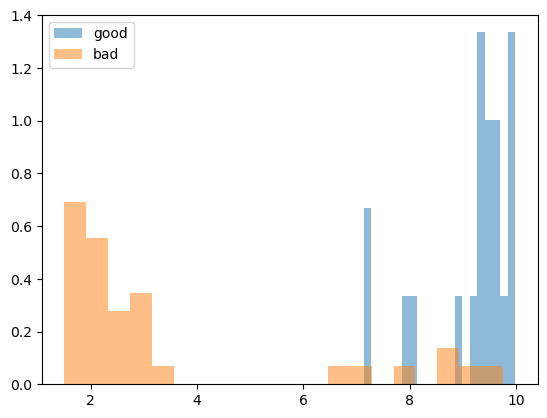

In [22]:
plt.hist(df_slice_good['k_xylem_sat'], bins = 20, label='good', alpha = 0.5, density=True);
plt.hist(df_slice_bad['k_xylem_sat'], bins = 20, label='bad', alpha = 0.5, density=True);
plt.legend()

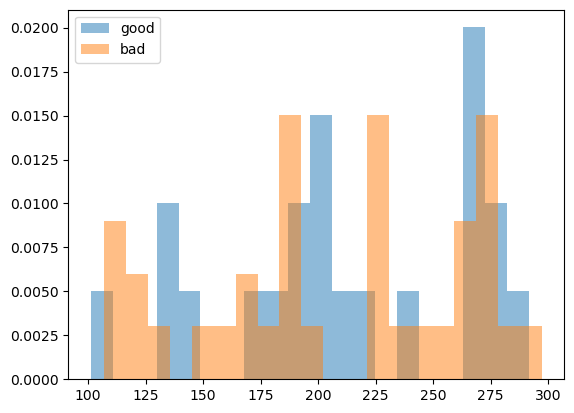

In [23]:
plt.hist(df_slice_good['kappa_stem'], bins = 20, label='good', alpha = 0.5, density=True);
plt.hist(df_slice_bad['kappa_stem'], bins = 20, label='bad', alpha = 0.5, density=True);
plt.legend()

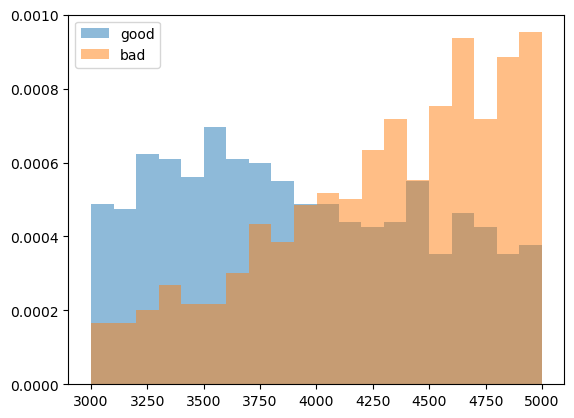

In [34]:
plt.hist(df_slice_good['k_latosa'], bins = 20, label='good', alpha = 0.5, density=True);
plt.hist(df_slice_bad['k_latosa'], bins = 20, label='bad', alpha = 0.5, density=True);
plt.legend()

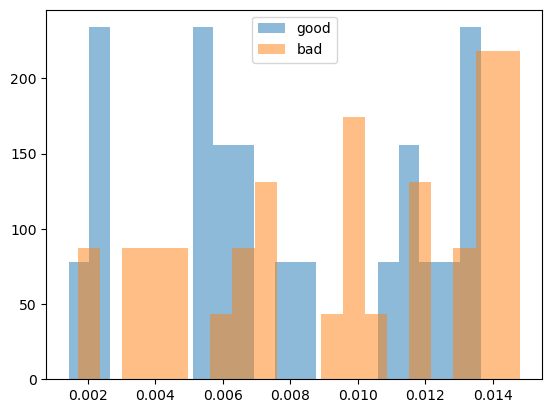

In [24]:
plt.hist(df_slice_good['g0'], bins = 20, label='good', alpha = 0.5, density=True);
plt.hist(df_slice_bad['g0'], bins = 20, label='bad', alpha = 0.5, density=True);
plt.legend()

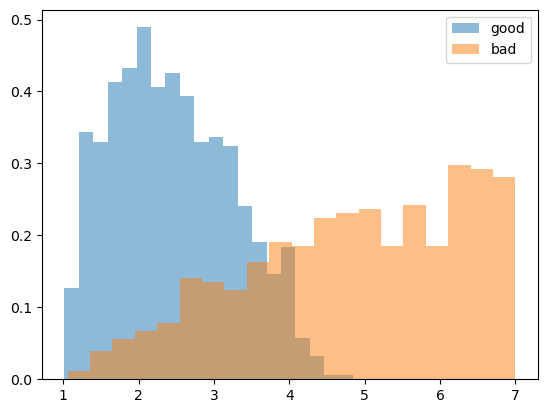

In [36]:
plt.hist(df_slice_good['g1'], bins = 20, label='good', alpha = 0.5, density=True);
plt.hist(df_slice_bad['g1'], bins = 20, label='bad', alpha = 0.5, density=True);
plt.legend()

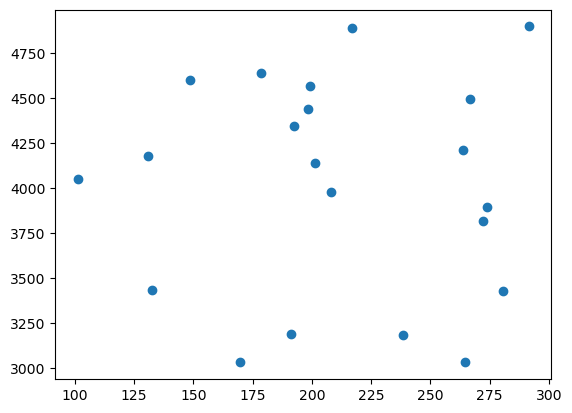

In [25]:
plt.scatter(df_slice_good['kappa_stem'],df_slice_good['k_latosa'])

In [29]:
df_slice_good.index

Index([ 42,  58,  95, 134, 149, 168, 184, 198, 240, 265, 275, 304, 315, 346,
       382, 397, 452, 474, 476, 494, 501],
      dtype='int64')

In [30]:
foi = [316, 265]
df_res

,k_xylem_sat,id,fid,kappa_stem,kappa_leaf,k_latosa,g0,g1,psi50_close,Gc,GPP,NEE,LE,H,PPFD
0,6.18118,0,0,121.13020,0.00312,4001.46525,0.01449,2.83859,-2.06625,0.010680,3.928816,4.020825,40.663996,49.993769,197.455804
1,5.77537,1,1,196.11046,0.00535,4392.46149,0.00600,5.43741,-2.05279,0.011070,4.473854,4.486626,45.135913,50.238065,194.789775
2,9.50915,2,2,154.68011,0.00139,4104.49471,0.00679,6.16339,-2.27905,0.011497,3.990095,4.109572,45.337542,50.255973,195.804731
3,4.54282,3,3,175.10126,0.00494,4548.98648,0.00183,4.43261,-2.12366,0.010830,4.437253,4.442511,45.191936,50.424329,193.214533
4,3.67538,4,4,245.70426,0.00297,3892.13019,0.01275,1.04112,-2.16902,0.011526,4.257422,4.198975,39.631217,50.292405,200.154844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,6.99870,507,507,212.72762,0.00113,4450.07691,0.00188,5.28895,-2.49578,0.011141,4.127183,4.219576,46.677255,50.576526,192.859534
508,5.86880,508,508,146.59599,0.00480,3619.05564,0.01200,3.59302,-2.10818,0.010594,3.991593,4.066256,41.768143,50.058648,200.845674
509,4.36618,509,509,128.72934,0.00437,3432.96208,0.01124,1.68985,-2.01664,0.011151,4.082893,4.083004,40.351561,50.187208,203.421166
510,5.65360,510,510,249.96661,0.00416,4951.31655,0.01252,4.69755,-2.37734,0.010859,4.439450,4.487969,43.475366,49.915271,190.494638


In [ ]:

foi = [2283]

In [26]:
df_slice_good

,k_xylem_sat,id,fid,kappa_stem,kappa_leaf,k_latosa,g0,g1,psi50_close,Gc,GPP,NEE,LE,H,PPFD
42,9.47556,42,42,132.68772,0.00504,3436.26040,0.00820,4.32425,-2.26467,0.010612,3.674143,3.815251,42.969231,50.163635,201.774609
58,8.01924,58,58,191.30658,0.00691,3191.69876,0.00560,3.30677,-2.31972,0.010554,3.693597,3.809766,42.337426,50.224516,204.560354
95,7.97740,95,95,178.45787,0.00796,4641.65114,0.01237,2.30172,-2.38409,0.010723,3.652241,3.832690,39.882396,49.992746,191.411771
134,9.71239,134,134,198.31366,0.00977,4439.94553,0.00596,3.62543,-2.34597,0.010534,3.681749,3.868078,41.551741,50.061947,192.588191
149,9.30985,149,149,264.61816,0.00365,3032.85087,0.00250,3.03468,-2.45683,0.010576,3.645697,3.760256,42.530351,50.313264,206.281349
168,9.57445,168,168,130.69407,0.00526,4181.30344,0.00144,1.70827,-2.32244,0.010999,3.684704,3.822804,39.712281,50.309136,195.276419
184,9.98901,184,184,263.71578,0.00112,4214.22826,0.00661,2.57278,-2.04796,0.010678,3.672283,3.825310,40.287497,50.080986,194.867053
198,9.89731,198,198,208.24863,0.00106,3977.88939,0.00234,2.13648,-2.31309,0.010797,3.627438,3.781800,40.315970,50.212978,196.727167
240,9.42552,240,240,280.75416,0.00160,3429.24524,0.00651,3.70381,-2.27235,0.010536,3.656722,3.797570,42.463492,50.181621,201.858870
265,9.39982,265,265,266.68775,0.00372,4493.96745,0.00524,2.35695,-2.40913,0.010689,3.570006,3.765055,39.994852,50.117352,192.157793


     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.1 sec.)
     Reading variable names and units... Done! (0.1 sec.)
     Reading all 1D variables... Done! (0.1 sec.)
0
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.1 sec.)
     Reading variable names and units... Done! (0.1 sec.)
     Reading all 1D variables... Done! (0.1 sec.)
1231


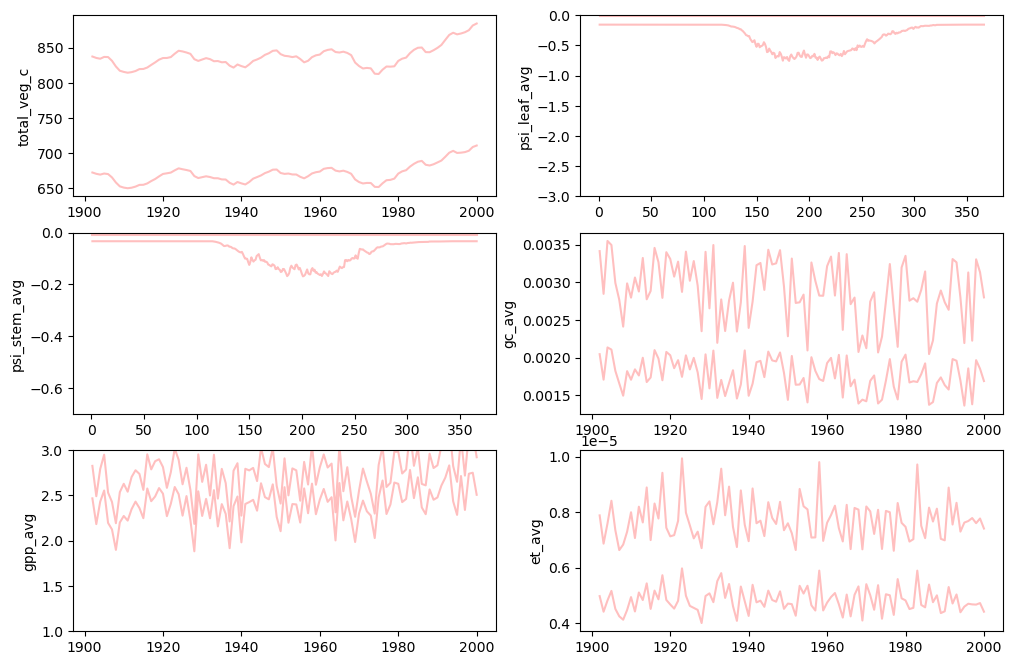

In [16]:
foi = [0, 1231]
fig = plt.figure(figsize=(12,8))

ax_veg = fig.add_subplot(3, 2, 1)
ax_psi_leaf = fig.add_subplot(3, 2, 2)
ax_psi_leaf24 = fig.add_subplot(3, 2, 3)
ax_gs= fig.add_subplot(3, 2, 4)
ax_gpp = fig.add_subplot(3, 2, 5)
ax_et = fig.add_subplot(3, 2, 6)

for fid in foi:
    parser = QNC_output_parser(os.path.join(OUTPUT_DIR,'output', str(fid)))
    parser.Read()
    output = parser.Available_outputs['transient']
    nc_output = QNC_ncdf_reader(os.path.join(OUTPUT_DIR, 'output', str(fid)),
                                            output.Categories,
                                            output.Identifier,
                                            output.Time_resolution
                                            )

    nc_output.Parse_env_and_variables()
    nc_output.Read_all_1D()
    nc_output.Close()
    dfs_veg = nc_output.Datasets_1D['VEG'].groupby(pd.Grouper(key='date', freq='1YE')).mean()
    
    minc = 500
    maxc = 600
    s = maxc-minc
    
    vegmean = dfs_veg['total_veg_c'].mean()
    print(fid)
    col = plt.cm.rainbow(-minc/s + vegmean/s)
    
    dfs_psi = nc_output.Datasets_1D['PHYD'].groupby(pd.Grouper(key='date', freq='d')).mean()
    dfs_assimi_year = nc_output.Datasets_1D['Q_ASSIMI'].groupby(pd.Grouper(key='date', freq='1YE')).mean()
    dfs_spq_yearly = nc_output.Datasets_1D['SPQ'].groupby(pd.Grouper(key='date', freq='1YE')).mean()
    
    dfs_psi['dayofyear'] = dfs_psi.index.dayofyear
    dfs_psi  = dfs_psi.groupby('dayofyear').mean()

    ax_veg.plot(dfs_veg['total_veg_c'], c = col, alpha = 0.25)

    
    ax_gpp.plot(dfs_assimi_year['gpp_avg'], c = col, alpha = 0.25)
    ax_gpp.set_ylim(1.0, 3.0)
    ax_psi_leaf.plot(dfs_psi['psi_leaf_avg'], c = col, alpha = 0.25)
    ax_psi_leaf.set_ylim(-3,0)
    ax_psi_leaf24.plot(dfs_psi['psi_stem_avg'], c = col, alpha = 0.25)
    ax_psi_leaf24.set_ylim(-0.7,0)
    ax_et.plot(dfs_spq_yearly['transpiration_avg'], c = col , alpha = 0.25)
    ax_gs.plot(dfs_assimi_year['gc_avg'], c = col, alpha = 0.25)

ax_veg.set_ylabel('total_veg_c')
ax_gpp.set_ylabel('gpp_avg')
ax_psi_leaf.set_ylabel('psi_leaf_avg')
ax_psi_leaf24.set_ylabel('psi_stem_avg')
ax_et.set_ylabel('et_avg')
ax_gs.set_ylabel('gc_avg')


plt.savefig(os.path.join(OUTPUT_DIR,"Overview.png"))
plt.show()


In [137]:
dfs_obs

,GPP
time,
2000-01-01 00:00:00,0.000000
2000-01-01 00:30:00,0.076432
2000-01-01 01:00:00,0.000000
2000-01-01 01:30:00,0.000000
2000-01-01 02:00:00,0.000000
...,...
2006-12-31 21:30:00,0.000000
2006-12-31 22:00:00,0.299952
2006-12-31 22:30:00,0.000000


In [29]:
from src.postprocessing.qnc_multi_fluxnet_comparer import QNC_Multi_Fluxnet_Comparer
comparer = QNC_Multi_Fluxnet_Comparer("DE-Hai")
var_list = comparer.Generate_Default_Fluxnet_Var_List()
comparer.Set_target_list(var_list)
comparer.Parse_Obs('/Net/Groups/BSI/data/OCN/evaluation/point/FLUXNET/v2/DE-Hai.2000-2006.obs.nc')


In [30]:
obs_var_collection.Target_variables[4].name

'LE'

In [31]:
comparer.get_obs_df(obs_var_collection.Target_variables[4])

,LE
time,
2000-01-01 00:00:00,-2.100149
2000-01-01 00:30:00,-1.096890
2000-01-01 01:00:00,-1.638050
2000-01-01 01:30:00,-1.227500
2000-01-01 02:00:00,-2.125300
...,...
2006-12-31 21:30:00,-11.273950
2006-12-31 22:00:00,-13.629350
2006-12-31 22:30:00,-13.594760


In [51]:
foi = range(0, 2000, 50)

     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.5 sec.)
     Reading variable names and units... Done! (0.5 sec.)
     Reading all 1D variables... Done! (0.1 sec.)
0
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.5 sec.)
     Reading variable names and units... Done! (0.5 sec.)
     Reading all 1D variables... Done! (0.1 sec.)
50
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.5 sec.)
     Reading variable names and units... Done! (0.5 sec.)
     Reading all 1D variables... Done! (0.1 sec.)
100
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.5 sec.)
     Reading variable names and units... Done! (0.5 sec.)
     Reading all 1D variables... Done! (0.1 sec.)
150
     Reading time variable...      Done! (0.0 sec.)
     Parsing time variable... Done! (0.5 sec.)
     Reading variable names and units... Done! (0.5 sec.)
  

Text(0, 0.5, 'lai')

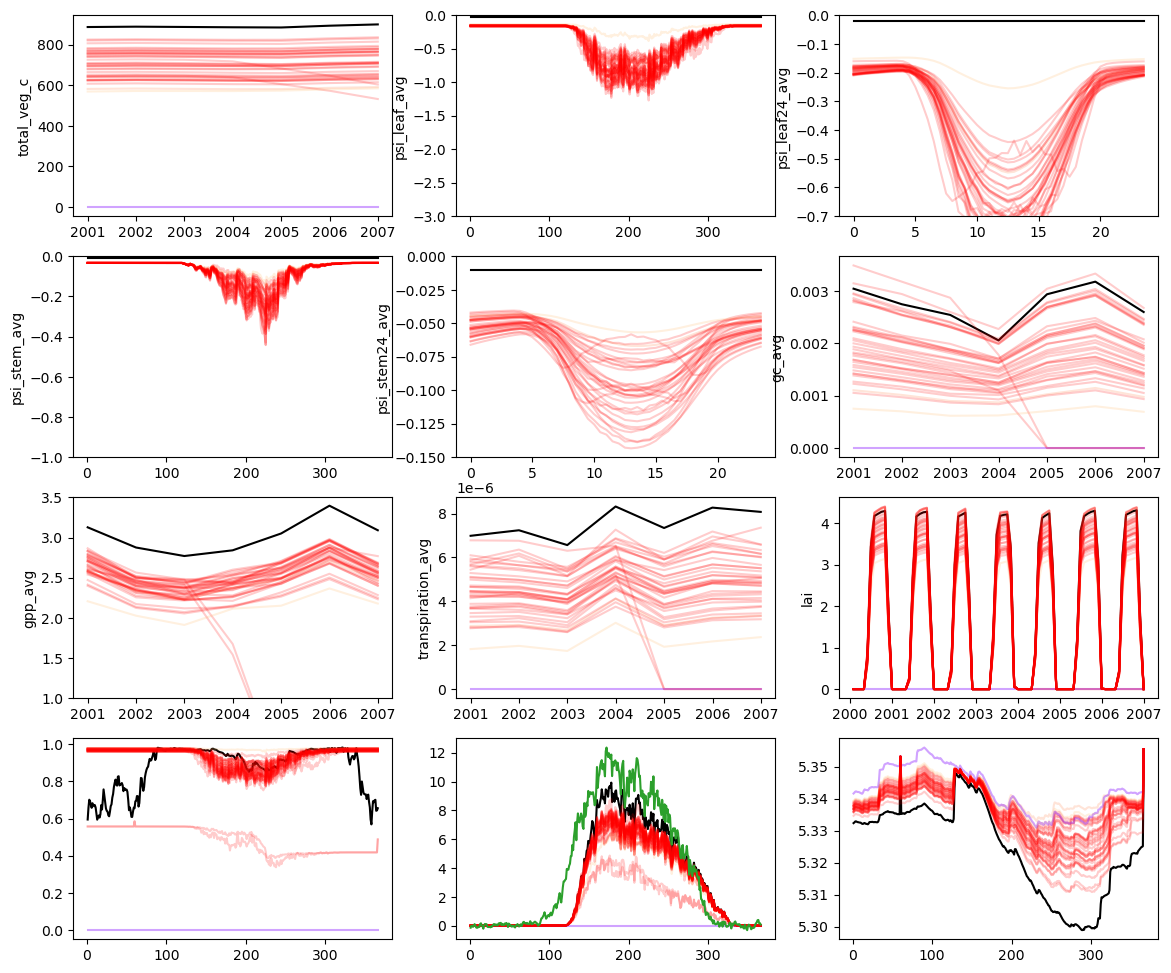

In [52]:

fig = plt.figure(figsize=(14,12))
ax_veg = fig.add_subplot(4, 3, 1)
ax_psi_leaf = fig.add_subplot(4, 3, 2)
ax_psi_leaf24 = fig.add_subplot(4, 3, 3)
ax_psi_stem = fig.add_subplot(4, 3, 4)
ax_psi_stem24 = fig.add_subplot(4, 3, 5)
ax_gs= fig.add_subplot(4, 3, 6)
ax_gpp = fig.add_subplot(4, 3, 7)
ax_et = fig.add_subplot(4, 3, 8)
ax_lai =fig.add_subplot(4,3,9)
ax_beta_gs =fig.add_subplot(4,3,10)
ax_gpp365 =fig.add_subplot(4,3,11)
ax_swc365 =fig.add_subplot(4,3,12)

list_month_gpp = []
list_month_le = []

for fid in foi:
    parser = QNC_output_parser(os.path.join(OUTPUT_DIR,'output', str(fid)))
    parser.Read()
    output = parser.Available_outputs['fluxnetdata']
    nc_output = QNC_ncdf_reader(os.path.join(OUTPUT_DIR, 'output', str(fid)),
                                            output.Categories,
                                            output.Identifier,
                                            output.Time_resolution
                                            )

    nc_output.Parse_env_and_variables()
    nc_output.Read_all_1D()
    nc_output.Close()
    dfs_veg = nc_output.Datasets_1D['VEG'].groupby(pd.Grouper(key='date', freq='1YE')).mean()
    
    minc = 500
    maxc = 600
    s = maxc-minc
    
    vegmean = dfs_veg['total_veg_c'].mean()
    print(fid)
    if fid == 0:
        col = 'black'
        
        alph = 1.0
    
    else:
        col = plt.cm.rainbow(-minc/s + vegmean/s)
        alph = 0.2
    
    dfs_psi = nc_output.Datasets_1D['PHYD'].groupby(pd.Grouper(key='date', freq='d')).mean()
    dfs_psi_hm = nc_output.Datasets_1D['PHYD']
    dfs_psi_hm['hour'] = dfs_psi_hm['date'].dt.hour
    dfs_psi_hm['minute'] = dfs_psi_hm['date'].dt.minute
    dfs_psi_hm = dfs_psi_hm.groupby(['hour', 'minute']).mean()
    
    
    dfs_beta = nc_output.Datasets_1D['Q_ASSIMI'].groupby(pd.Grouper(key='date', freq='d')).mean()
    
    dfs_assimi_year = nc_output.Datasets_1D['Q_ASSIMI'].groupby(pd.Grouper(key='date', freq='1YE')).mean()
    dfs_assimi_month = nc_output.Datasets_1D['Q_ASSIMI'].groupby(pd.Grouper(key='date', freq='1ME')).mean()
    dfs_assimi = nc_output.Datasets_1D['Q_ASSIMI']
    dfs_spq_yearly = nc_output.Datasets_1D['SPQ'].groupby(pd.Grouper(key='date', freq='1YE')).mean()
    dfs_spq_monthly = nc_output.Datasets_1D['SPQ'].groupby(pd.Grouper(key='date', freq='1ME')).mean()
    dfs_spq = nc_output.Datasets_1D['SPQ']
    dfs_spq_day = nc_output.Datasets_1D['SPQ'].groupby(pd.Grouper(key='date', freq='d')).mean()
    
    dfs_lai_monthly = nc_output.Datasets_1D['VEG'].groupby(pd.Grouper(key='date', freq='1ME')).mean()
    
    dfs_psi['dayofyear'] = dfs_psi.index.dayofyear
    dfs_psi  = dfs_psi.groupby('dayofyear').mean()
    
    dfs_beta['dayofyear'] = dfs_beta.index.dayofyear
    dfs_beta  = dfs_beta.groupby('dayofyear').mean()
    
    dfs_spq_day['dayofyear'] = dfs_spq_day.index.dayofyear
    dfs_spq_day  = dfs_spq_day.groupby('dayofyear').mean()

    ax_veg.plot(dfs_veg['total_veg_c'], c = col, alpha = alph)

    
    ax_gpp.plot(dfs_assimi_year['gpp_avg'], c = col, alpha = alph)
    ax_gpp.set_ylim(1.0, 3.5)
    
    ax_psi_leaf.plot(dfs_psi['psi_leaf_avg'], c = col, alpha = alph)
    ax_psi_leaf.set_ylim(-3,0)
    
    ax_psi_leaf24.plot(np.arange(0, 24, 0.5), dfs_psi_hm['psi_leaf_avg'].values, c = col, alpha = alph)
    ax_psi_leaf24.set_ylim(-0.7,0)
    
    ax_psi_stem.plot(dfs_psi['psi_stem_avg'], c = col, alpha = alph)
    ax_psi_stem.set_ylim(-1,0)
    
    ax_psi_stem24.plot(np.arange(0, 24, 0.5), dfs_psi_hm['psi_stem_avg'].values, c = col, alpha = alph)
    ax_psi_stem24.set_ylim(-0.15,0)
    
    
    ax_et.plot(dfs_spq_yearly['transpiration_avg'], c = col , alpha = alph)
    ax_gs.plot(dfs_assimi_year['gc_avg'], c = col, alpha = alph)
    
    
    ax_lai.plot(dfs_lai_monthly['LAI'], c = col, alpha = alph)
    
    
    ax_beta_gs.plot(dfs_beta['beta_gs'], c = col, alpha = alph)
    
        
    ax_gpp365.plot(dfs_beta['gpp_avg'], c = col, alpha = alph)
    
    ax_swc365.plot(dfs_spq_day['water_content_soil'], c = col, alpha = alph)
    
    list_month_gpp.append(dfs_assimi_month)
    list_month_le.append(dfs_spq_monthly)
    
df =comparer.get_obs_df(obs_var_collection.Target_variables[1])
df['dayofyear'] = df.index.dayofyear
df = df.groupby('dayofyear').mean()
ax_gpp365.plot(df['GPP'], c = 'tab:green')

ax_veg.set_ylabel('total_veg_c')
ax_gpp.set_ylabel('gpp_avg')
ax_psi_leaf.set_ylabel('psi_leaf_avg')
ax_psi_leaf24.set_ylabel('psi_leaf24_avg')
ax_psi_stem.set_ylabel('psi_stem_avg')
ax_psi_stem24.set_ylabel('psi_stem24_avg')
ax_et.set_ylabel('transpiration_avg')
ax_gs.set_ylabel('gc_avg')
ax_lai.set_ylabel('lai')

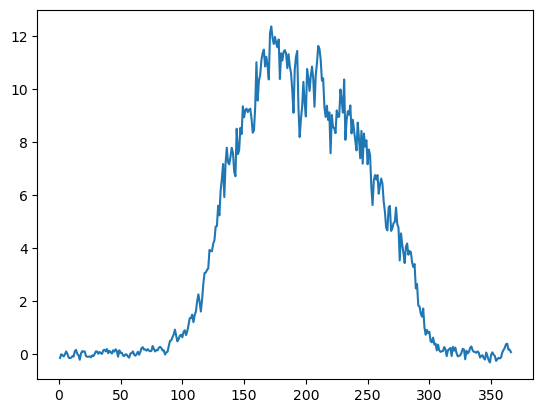

In [44]:
df =comparer.get_obs_df(obs_var_collection.Target_variables[1])
df['dayofyear'] = df.index.dayofyear
df = df.groupby('dayofyear').mean()
plt.plot(df['GPP'])

(0.95, 1.05)

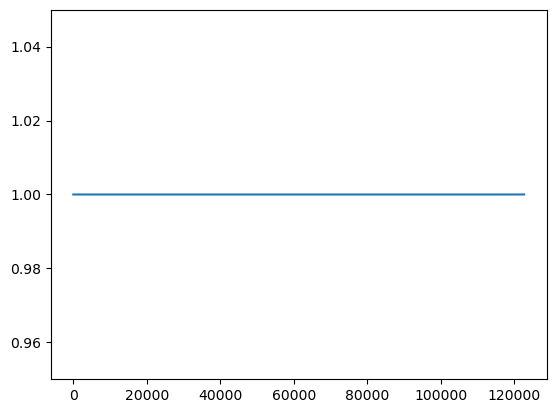

In [45]:
plt.plot(nc_output.Datasets_1D['VEG']['beta_sinklim'])
plt.ylim(0.95,1.05)

In [201]:
nc_output.Dataset_Names_1D["VEG"]

['vegpool_leaf_C',
 'vegpool_fine_root_C',
 'vegpool_coarse_root_C',
 'vegpool_sap_wood_C',
 'vegpool_heart_wood_C',
 'vegpool_labile_C',
 'vegpool_reserve_C',
 'vegpool_fruit_C',
 'total_veg_c',
 'height',
 'diameter',
 'beta_sinklim',
 'LAI',
 'growth_resp_avg',
 'maint_resp_avg',
 'npp_avg']

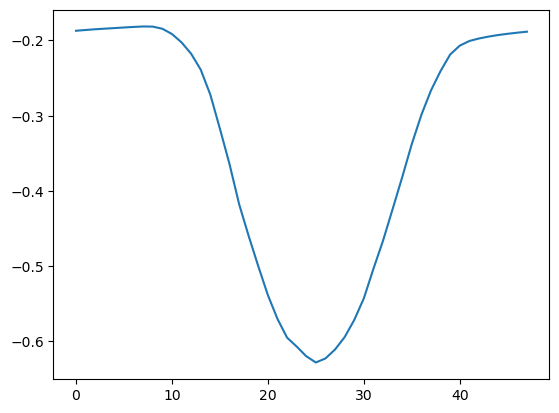

In [41]:
dt = nc_output.Datasets_1D['PHYD']
dt['hour'] = dt['date'].dt.hour
dt['minute'] = dt['date'].dt.minute
dt_avg = dt.groupby(['hour', 'minute']).mean()
plt.plot(dt_avg['psi_leaf_avg'].values)

In [27]:
df_month = comparer.get_obs_df(obs_var_collection.Target_variables[4]).groupby(pd.Grouper(freq='1ME')).mean()
plt.plot(df_month * 1.2, alpha = 1, label = 'flux')
for i in range(0,len(foi)):
    plt.plot( -list_month_le[i]['qle_avg'], alpha = 0.5, label = f'mod_{foi[i]}')
plt.legend()

NameError: name 'comparer' is not defined

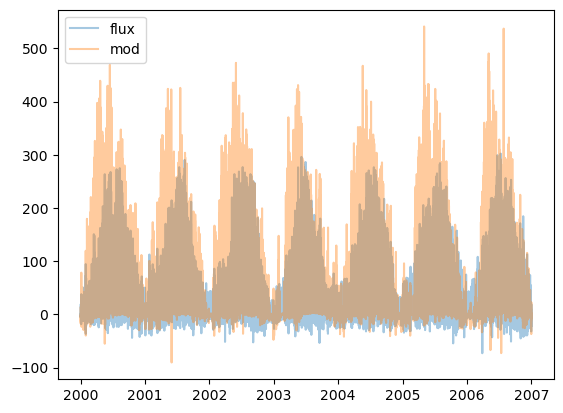

In [34]:
plt.plot(comparer.get_obs_df(obs_var_collection.Target_variables[4]), alpha = 0.4, label = 'flux')
plt.plot(dfs_spq['date'], -dfs_spq['qle_avg'], alpha = 0.4, label = 'mod')
plt.legend()

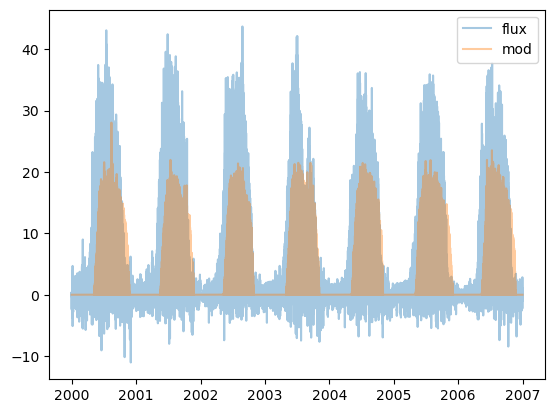

In [35]:
plt.plot(comparer.get_obs_df(obs_var_collection.Target_variables[1]), alpha = 0.4, label = 'flux')
plt.plot(dfs_assimi['date'], dfs_assimi['gpp_avg'], alpha = 0.4, label = 'mod')
plt.legend()

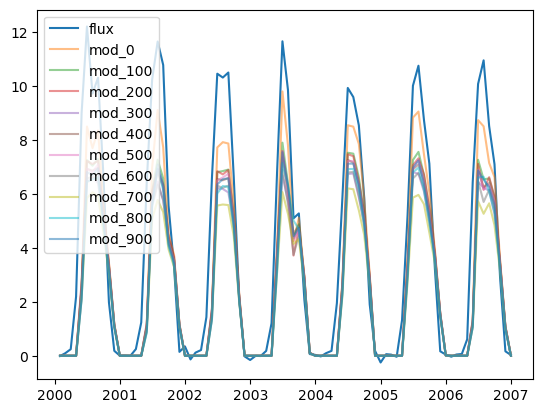

In [36]:
df_month = comparer.get_obs_df(obs_var_collection.Target_variables[1]).groupby(pd.Grouper(freq='1ME')).mean()
plt.plot(df_month['GPP'], alpha = 1.0 ,label = 'flux')
for i in range(0,len(foi)):
    plt.plot( list_month_gpp[i]['gpp_avg'], alpha = 0.5, label = f'mod_{foi[i]}')
plt.legend()
plt.legend()

In [124]:
df_month

,GPP
time,
2000-01-31,-0.011524
2000-02-29,0.092383
2000-03-31,0.242749
2000-04-30,2.193134
2000-05-31,8.996586
...,...
2006-08-31,8.505722
2006-09-30,7.094776
2006-10-31,2.922130
